# PosEmotion

Before running the iPython Notebook, it is important to install all necessary packages. To do that, in terminal type the command <code>pip install -r requirements.txt</code>.

In [1]:
import cv2
import tools.davinci as dv
import tools.metrics as ms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from imblearn.over_sampling import SMOTE
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.models import Sequential
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import davies_bouldin_score, silhouette_score, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from tools.detector import PoseLandmarkerDetector

## Step 1: Preprocessing

### Data Preparation

Before operating with data, it's important to see how the data looks like. For that purpose, let's convert <code>annotation.csv</code> file to pandas Dataframe. As we can see below, the Dataframe has the following structure:

- Video Tag → The video identification present in YouTube. Use it to retrieve the source video. 
In this version of the dataset, the videos are present in the "/Videos" folder.
- Clip Id → Id for each clip from a source video. This identification is unique within a source video. 
For a certain “Video Tag” with an “Clip Id”, the “Person Id” will be unique to a certain person. 
- Labels → An arrays of arrays containing the labels given by each annotator of the dataset.
- Frame Number → The frame that was used for that annotation
- X → Starting position of the bounding box in the x-axis
- Y → Starting position of the bounding box in the y-axis
- Width → % of the width of the video used as offset for “X”
- Height → % of the height of the video used as offset for “Y”
- Person Id → Integer to identify a certain person for clips with the same “Video Tag” and “Clip Id”

In [2]:
df = pd.read_csv("assets/annotations/annotations.csv")
df.head()

,Video Tag,Clip Id,Labels,Frame Number,X,Y,Width,Height,Person Id
0,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19532,41.965200,4.873195,44.216991,94.802684,0
1,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19538,41.564836,4.874640,44.216991,94.802684,0
2,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19544,41.164472,4.876086,44.216991,94.802684,0
3,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19550,40.764108,4.877532,44.216991,94.802684,0
4,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19556,39.646728,5.014136,44.216991,94.802684,0


Each combination of <code>Video Tag</code>, <code>Clip Id</code> and <code>Person Id</code> represents a unique emotion related to a person. Therefore, we can split these emotions into segments.

In [3]:
%%script True  # Comment this line to run the code below

extractor = Extractor(
    "assets/annotations/annotations.csv",
    "assets/videos",
    "assets/frames"
)

extractor.extract_frames()

### Data Augmentation

Data augmentation will help to increase the dataset in size, adding robustness and improvng the accuracy of the model. For data augmentation, the following techniques will be applied for each image:
- Vertical flipping
- Horizontal flipping
- Random rotations (from 30 to 330 degrees)

In [4]:
%%script True  # Comment this line to run the code below

extractor.flip_frames(target="assets/frames_vflip", axis=0)
extractor.flip_frames(target="assets/frames_hflip", axis=1)
extractor.random_rotate_frames(target="assets/frames_rotated", minr=30, maxr=330)

### Skeleton Joints Extraction

To extract keypoints, the PoseLandmarker will be used. It is not only estimates the pose of a human, but also depth, which can help to compute real distances, and not only projections. For each of the approaches, a different dataframe will be created with coordinates of keypoints.

- For each frame, a person will be detected (using ground truth).
- Mask will be applied for the rest of the frame (to avoid detecting multiple people).
- After for each frame pose detection algorithm will be applied.
- At the end, csv file with keypoints will be created.

In [5]:
detector = PoseLandmarkerDetector("models/pose_landmarker_full.task")
category = "keypoints3D_plm_aligned"

I0000 00:00:1718973381.607155  952398 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1718973381.683428  952595 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1718973381.697259  952599 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/deniskrylov/Developer/PosEmotion/.venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
I0000 00:00:1718973381.734528  952398 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M3 Pro

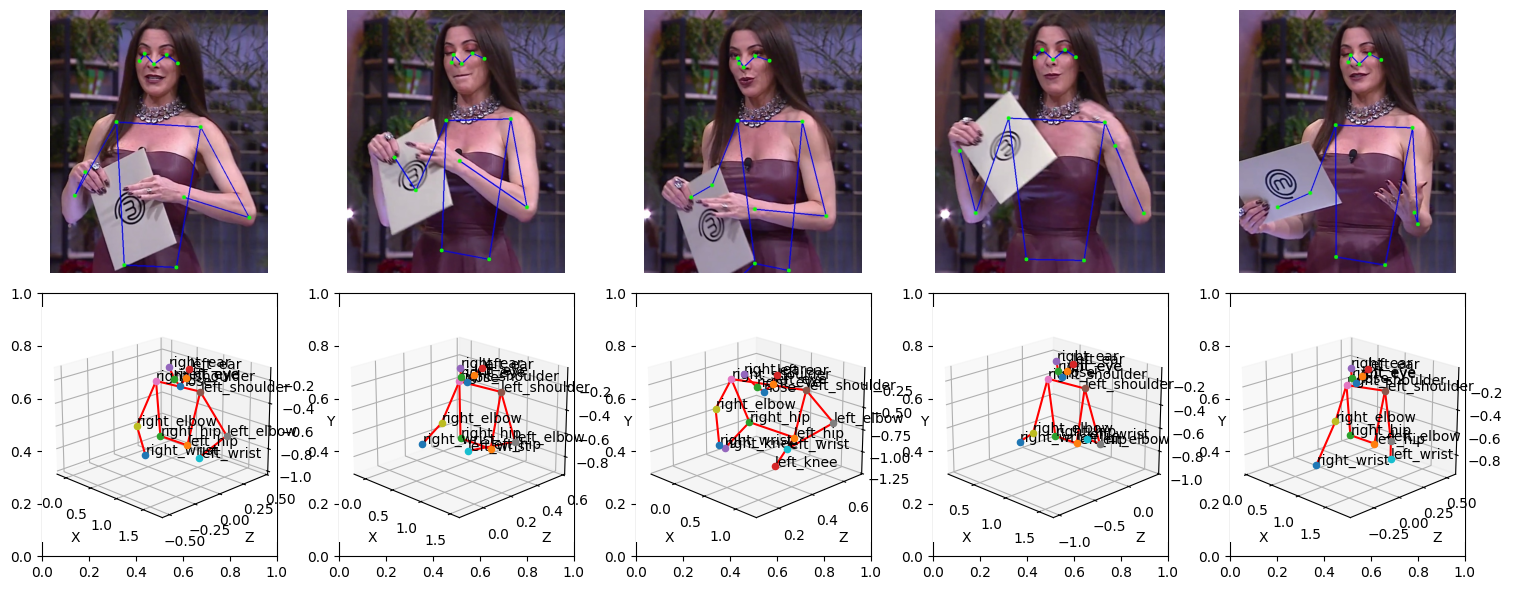

In [6]:
image_paths = [
    "assets/frames/aJKL0ahn1Dk_0.jpg",
    "assets/frames/aJKL0ahn1Dk_5.jpg",
    "assets/frames/aJKL0ahn1Dk_10.jpg",
    "assets/frames/aJKL0ahn1Dk_15.jpg",
    "assets/frames/aJKL0ahn1Dk_20.jpg"
]

fig, axes = plt.subplots(2, len(image_paths), figsize=(15, 6), gridspec_kw={'height_ratios': [1, 1]})

for i, image_path in enumerate(image_paths):
    image = plt.imread(image_path)
    result = detector.detect(image_path)
    result_aligned = detector.detect(image_path, align=True)
    img_bytes = dv.draw(result)
    
    img_np_array = np.frombuffer(img_bytes, dtype=np.uint8)
    img = cv2.imdecode(img_np_array, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    axes[0][i].imshow(img)
    axes[0][i].axis("off")

    ax = fig.add_subplot(2, len(image_paths), len(image_paths) + i + 1, projection='3d')
    dv.visualize(result_aligned, ax)

plt.tight_layout()
plt.show()

In [7]:
%%script True  # Comment this line to run the code below

def apply_model(model, df, target, output_csv):
    keypoints = model.detect_multi(df, target, depth=True, align=True)
    result_df = pd.concat(keypoints, axis=1, ignore_index=True).T
    result_df.to_csv(output_csv, index=False)

apply_model(
    detector,
    df,
    "assets/frames",
    f"assets/annotations/{category}.csv"
)

plm_df = pd.read_csv(f"assets/annotations/{category}.csv")
plm_df.head()

### Combine all DataFrames

In [8]:
plm_df = pd.read_csv(f"assets/annotations/{category}.csv")
plm_df_merged = pd.concat([df, plm_df], axis=1)
print("plm_df_merged shape:", plm_df_merged.shape)

combined_df = pd.concat([plm_df_merged], axis=0).reset_index(drop=True)
print("combined_df shape:", combined_df.shape)
combined_df.head()

plm_df_merged shape: (8087, 60)
combined_df shape: (8087, 60)


,Video Tag,Clip Id,Labels,Frame Number,X,Y,Width,Height,Person Id,nose_X,...,left_knee_Z,right_knee_X,right_knee_Y,right_knee_Z,left_ankle_X,left_ankle_Y,left_ankle_Z,right_ankle_X,right_ankle_Y,right_ankle_Z
0,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19532,41.965200,4.873195,44.216991,94.802684,0,1.188313,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19538,41.564836,4.874640,44.216991,94.802684,0,1.208457,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19544,41.164472,4.876086,44.216991,94.802684,0,1.356732,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19550,40.764108,4.877532,44.216991,94.802684,0,1.273436,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19556,39.646728,5.014136,44.216991,94.802684,0,0.760523,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Cleaning

According to [Wei Tang](https://www.mdpi.com/1424-8220/22/11/4245), frames in which body parts were occluded or lost were excluded from further analysis, because the skeletons in these frames could not be detected correctly using the current 2D pose estimation algorithm. The necessary body parts will be determined as torso, left and right hands. The position of head and legs will be ommited.

In [9]:
# Remove all columns that represent legs
columns_drop = combined_df.columns[combined_df.columns.get_loc('right_hip_Z')+1:]
cleaned_df = combined_df.drop(columns=columns_drop)

# Remove rows that have NaN values in all necessary body parts
body_parts = cleaned_df.columns[cleaned_df.columns.get_loc('right_ear_Z')+1:]
cleaned_df = cleaned_df.dropna(subset=body_parts, how='all')

cleaned_df[body_parts] = cleaned_df[body_parts].fillna(cleaned_df[body_parts].mean())
# interpolate_columns = cleaned_df.columns[cleaned_df.columns.get_loc('Person Id')+1:]
# cleaned_df[interpolate_columns] = cleaned_df[interpolate_columns].interpolate(method='linear', axis=1)
cleaned_df = cleaned_df.reset_index(drop=True)

print("cleaned_df shape:", cleaned_df.shape)
cleaned_df.head()

cleaned_df shape: (3675, 48)


,Video Tag,Clip Id,Labels,Frame Number,X,Y,Width,Height,Person Id,nose_X,...,left_wrist_Z,right_wrist_X,right_wrist_Y,right_wrist_Z,left_hip_X,left_hip_Y,left_hip_Z,right_hip_X,right_hip_Y,right_hip_Z
0,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19532,41.965200,4.873195,44.216991,94.802684,0,1.188313,...,-0.142207,1.408239,0.600841,-0.498228,0.486243,0.967889,0.422609,-0.058462,0.967889,0.422609
1,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19538,41.564836,4.874640,44.216991,94.802684,0,1.208457,...,-0.047420,1.411503,0.647568,-0.379691,0.477585,0.970022,0.450328,-0.069194,0.970022,0.450328
2,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19544,41.164472,4.876086,44.216991,94.802684,0,1.356732,...,-0.240214,1.706023,0.634923,-0.747468,0.495469,0.975558,0.434683,0.031373,0.975558,0.434683
3,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19550,40.764108,4.877532,44.216991,94.802684,0,1.273436,...,-0.257033,1.492726,0.675397,-0.566822,0.495414,0.967415,0.438220,-0.028613,0.967415,0.438220
4,aJKL0ahn1Dk,1,"[['Happy'], ['Happy'], ['Happy']]",19556,39.646728,5.014136,44.216991,94.802684,0,0.760523,...,-0.010090,1.091009,0.545888,-0.333109,0.509818,0.943826,0.455250,0.001599,0.943826,0.455250


## Step 2: Feature Extraction

#### Segment Normalization

Before clustering, we needs to ensure that all segments have identical size:
- If the size of a segment $s \lt x$, then equally distant frames will be duplicated to the size of $x$.
- If the size of a segment $s \gt x$, then equally distant frames will be removed to the size of $x$.
- If the size of a segment $s = x$, then segment normalization won't be applied.

In [10]:
segments = ms.segment(cleaned_df)
print("Total number of segments:", len(segments))
print("Original (first 5):", [segment.indices() for segment in segments][:5])

norm_segments = [ms.normalize_segment(segment, target_size=5) for segment in segments]
norm_df = pd.concat([segment.df for segment in norm_segments], ignore_index=True)

norm_segments = ms.segment(norm_df)
print("Total number of normalized segments:", len(norm_segments))
print("Normalized (first 5):", [norm_segment.indices() for norm_segment in norm_segments][:5])

Total number of segments: 326
Original (first 5): [(0, 56), (57, 70), (71, 83), (84, 98), (99, 110)]
Total number of normalized segments: 326
Normalized (first 5): [(0, 4), (5, 9), (10, 14), (15, 19), (20, 24)]


#### Vector Features

Each movement of each joint can be represented as a vector with its own magnitude, direction and slope.

In [11]:
segment = norm_segments[0]

v_f = segment.get_vectors(["nose", "left_shoulder", "right_shoulder", "left_elbow", 
                           "right_elbow", "left_wrist", "right_wrist"])
v_f

{'Label': 'Happy',
 'Distance_Hip_nose_0': 1.3327455032228916,
 'Distance_Hip_nose_1': 1.1238099496529883,
 'Distance_Hip_nose_2': 1.2601088513660357,
 'Distance_Hip_nose_3': 1.4087647507454302,
 'Distance_Hip_nose_4': 1.8601119338883574,
 'Distance_Hip_left_shoulder_0': 0.7551304538241586,
 'Distance_Hip_left_shoulder_1': 0.683742174785243,
 'Distance_Hip_left_shoulder_2': 0.6433206853777564,
 'Distance_Hip_left_shoulder_3': 0.9178587695347747,
 'Distance_Hip_left_shoulder_4': 1.0468926176983264,
 'Distance_Hip_right_shoulder_0': 0.5890423972097525,
 'Distance_Hip_right_shoulder_1': 0.5778024028634507,
 'Distance_Hip_right_shoulder_2': 0.5647794230056721,
 'Distance_Hip_right_shoulder_3': 0.5554607934921515,
 'Distance_Hip_right_shoulder_4': 0.7159771428202079,
 'Distance_Hip_left_elbow_0': 1.0034493385904015,
 'Distance_Hip_left_elbow_1': 0.8618879887545235,
 'Distance_Hip_left_elbow_2': 1.0029380833355892,
 'Distance_Hip_left_elbow_3': 0.8344281229009755,
 'Distance_Hip_left_elbow_4

#### Emotion Labeling

Before pose detection, we need to convert our dataset in such a way, that the array of <code>Labels</code> column will be converted to multiple columns, where each column represents a particular emotion. In that case for each segment the number of each emotion will be calculated (e.g. <code>[[Happy, Sad, Happy], [Happy, Happy, Angry]]</code> will be converted to <code>{Happy: 4, Sad: 1, Angry: 1, Fear: 0, ...}</code>).

In [12]:
emotion_count = segment.count_emotions()

print("Emotion count:", emotion_count)

Emotion count: {'Happy': 13, 'Sad': 0, 'Fear': 0, 'Surprise': 0, 'Disgust': 0, 'Anger': 0, 'Neutral': 2}


## Step 3: Clustering

### Prepare data to cluster

In [13]:
features = {}
pairs = ["nose", "left_shoulder", "right_shoulder", "left_elbow", "right_elbow", "left_wrist", "right_wrist"]

for i in range(len(norm_segments)):
    feature = norm_segments[i].get_vectors(pairs=pairs)
    features[f"s_{i}"] = feature

features_df = pd.DataFrame.from_dict(features, orient='index')
print(features_df.shape)
features_df.head()

(326, 36)


,Label,Distance_Hip_nose_0,Distance_Hip_nose_1,Distance_Hip_nose_2,Distance_Hip_nose_3,Distance_Hip_nose_4,Distance_Hip_left_shoulder_0,Distance_Hip_left_shoulder_1,Distance_Hip_left_shoulder_2,Distance_Hip_left_shoulder_3,...,Distance_Hip_left_wrist_0,Distance_Hip_left_wrist_1,Distance_Hip_left_wrist_2,Distance_Hip_left_wrist_3,Distance_Hip_left_wrist_4,Distance_Hip_right_wrist_0,Distance_Hip_right_wrist_1,Distance_Hip_right_wrist_2,Distance_Hip_right_wrist_3,Distance_Hip_right_wrist_4
s_0,Happy,1.332746,1.123810,1.260109,1.408765,1.860112,0.755130,0.683742,0.643321,0.917859,...,1.627360,1.421838,1.843423,1.053255,1.163164,1.552138,1.677665,1.048872,0.420566,1.000925
s_1,Fear,1.192243,0.681414,0.604389,0.562157,0.584692,0.341731,0.356715,0.416692,0.504377,...,1.231772,0.659564,0.785459,0.677227,0.693008,0.546131,0.565748,0.842214,0.504759,0.673853
s_2,Happy,0.906257,0.856539,0.659854,1.121256,0.359307,0.319396,0.317791,0.277120,0.361029,...,0.822922,0.243156,0.288264,0.332892,0.438216,1.776451,1.661954,0.732774,1.350100,0.657361
s_3,Neutral,0.457688,0.575967,0.662890,0.768367,2.299095,0.614781,0.375890,0.406101,0.304846,...,0.573469,0.661654,0.729514,0.651671,2.981377,0.262651,0.407449,0.439063,0.590760,3.013230
s_4,Happy,0.657182,0.797837,0.821187,0.643455,0.910598,0.221279,0.293859,0.307756,0.364841,...,0.351612,0.283039,0.313529,0.312549,0.342463,0.682933,0.758759,0.665052,0.695627,0.744579


### Removing underrepresented classes

Original label counts:
Label
Neutral     161
Happy        87
Anger        42
Sad          11
Surprise     10
Disgust       8
Fear          7
Name: count, dtype: int64

After removing some labels:
Label
Neutral    161
Happy       87
Anger       42
Name: count, dtype: int64


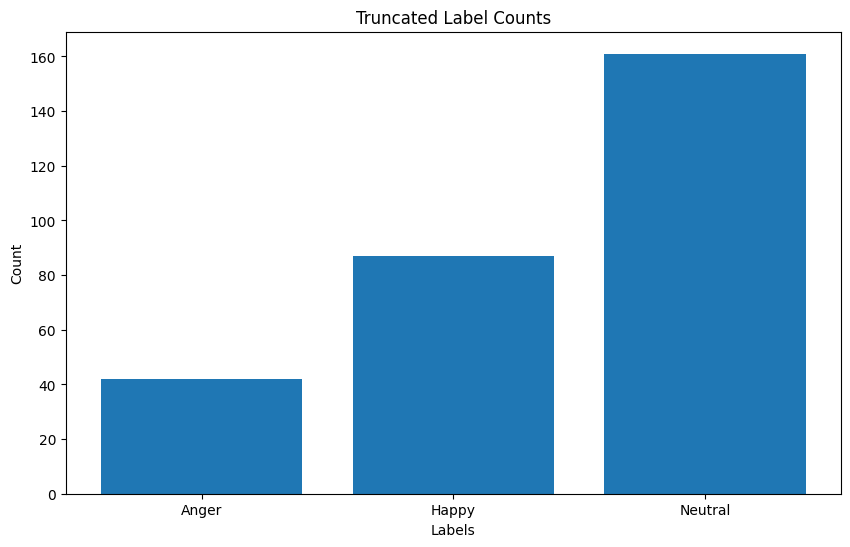

In [14]:
def plot_label_counts(labels, title, x="Labels", y="Count"):
    unique_labels, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, counts)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.show()

label_counts = features_df['Label'].value_counts()
print("Original label counts:")
print(label_counts)

labels_to_remove = ["Sad", "Surprise", "Disgust", "Fear"]
trunc_features_df = features_df[~features_df['Label'].isin(labels_to_remove)]
label_counts = trunc_features_df['Label'].value_counts()
print("\nAfter removing some labels:")
print(label_counts)

plot_label_counts(trunc_features_df["Label"], title="Truncated Label Counts")

### Hierarchical Clustering

In [104]:
scaler = StandardScaler()

data = features_df.drop(columns=['Label'])
scaled_data = scaler.fit_transform(data)

cluster = AgglomerativeClustering(n_clusters=7, metric='euclidean', linkage='ward')
cluster_labels = cluster.fit_predict(scaled_data)

silhouette_avg = silhouette_score(scaled_data, cluster_labels)
print(f'Silhouette Score: {silhouette_avg}')
davies_bouldin = davies_bouldin_score(scaled_data, cluster_labels)
print(f'Davies-Bouldin Index: {davies_bouldin}')

# pairplot = sns.pairplot(data[:, :10], hue='Cluster', palette='rainbow')
# pairplot.figure.suptitle("Pairplot of Clusters (for the first 10 columns)", y=1.02)
# plt.show()

Silhouette Score: 0.14284147827988466
Davies-Bouldin Index: 1.8788974513846977


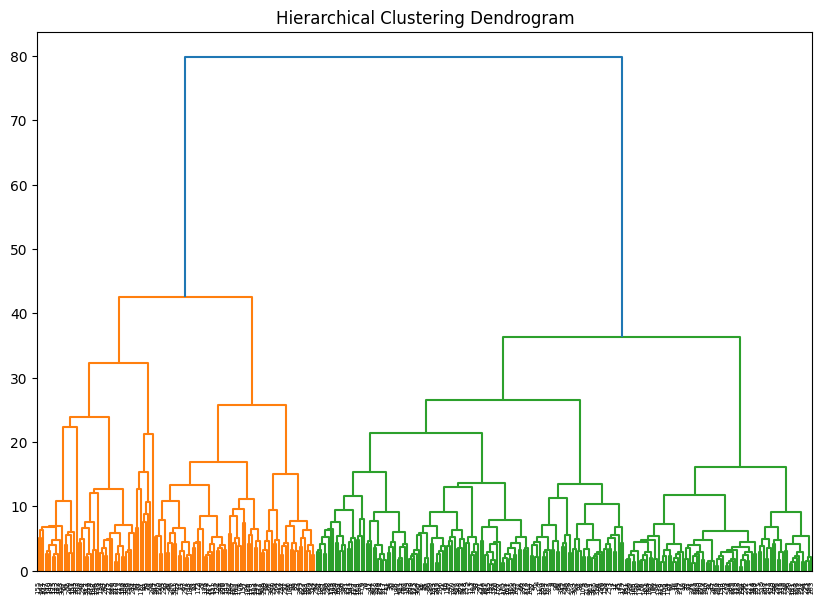

In [105]:
linked = linkage(scaled_data, metric="euclidean", method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

## Step 4: Classification

In [17]:
RANDOM_STATE = 42
NUM_CLASSES = 3
TEST_SIZE = 0.15

scaler = StandardScaler()
label_encoder = LabelEncoder()

X = trunc_features_df.drop(['Label'], axis=1)
y = trunc_features_df['Label']
X_scaled = scaler.fit_transform(X)
labels = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print("X_train:", X_train.shape, "X_test:", X_test.shape)

smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print("X_resampled:", X_resampled.shape, "y_resampled:", y_resampled.shape)

X_train: (246, 35) X_test: (44, 35)
X_resampled: (342, 35) y_resampled: (342,)


### Support Vector Machines (SVM)

Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best score: 0.7193520886615516
Accuracy: 63.64%
Precision: 0.64
Recall: 0.64
F1-Score: 0.62


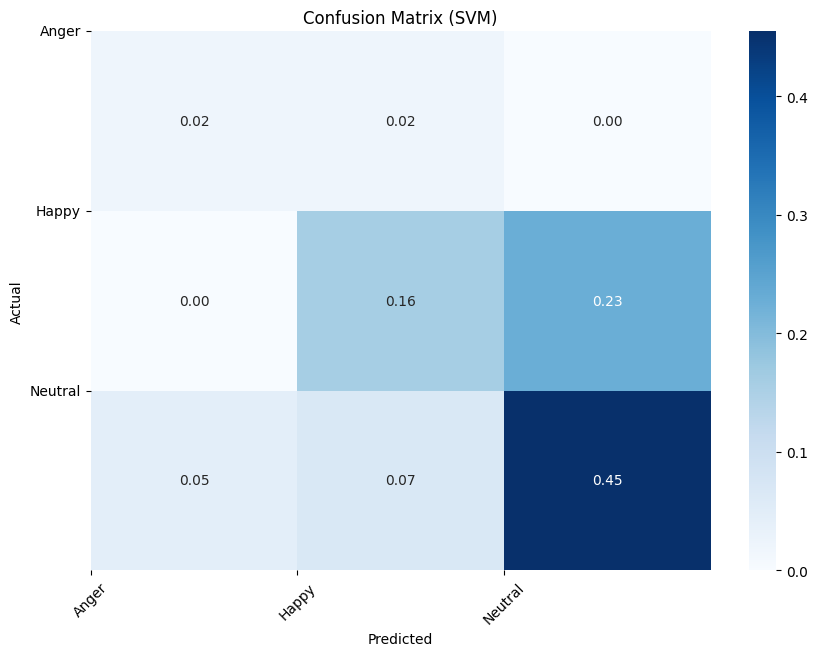

In [18]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf']
}

svm = SVC()
grid_search = GridSearchCV(svm, param_grid)
grid_search.fit(X_resampled, y_resampled)
y_pred = grid_search.predict(X_test)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (SVM)')
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=label_encoder.classes_, rotation=45)
plt.yticks(ticks=np.arange(NUM_CLASSES), labels=label_encoder.classes_, rotation=0)
plt.show()

### Random Forest

Accuracy: 43.18%
Precision: 0.44
Recall: 0.43
F1-Score: 0.39


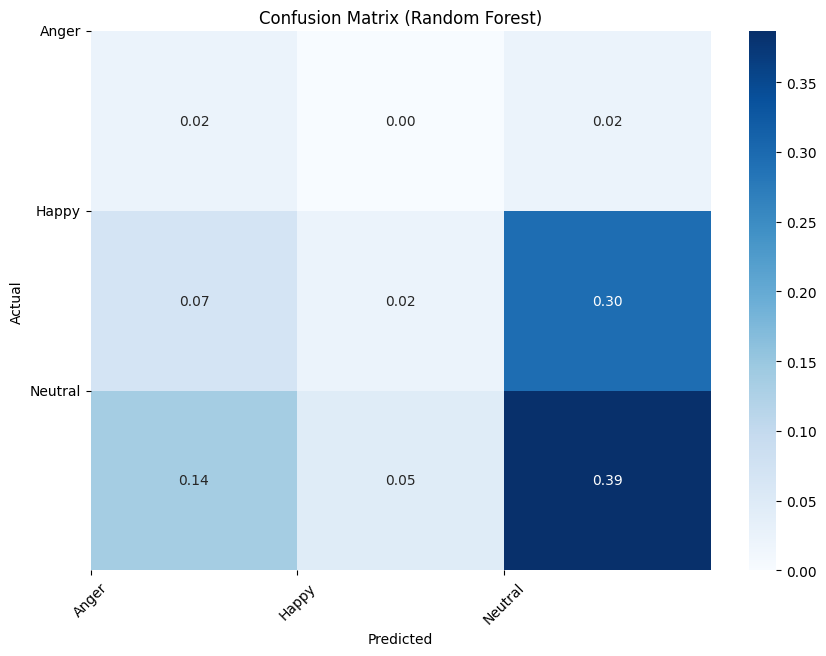

In [19]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf.fit(X_resampled, y_resampled)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Random Forest)')
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=label_encoder.classes_, rotation=45)
plt.yticks(ticks=np.arange(NUM_CLASSES), labels=label_encoder.classes_, rotation=0)
plt.show()

### Neural Network

Epoch 1/100


/Users/deniskrylov/Developer/PosEmotion/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4099 - loss: 1.2440 - val_accuracy: 0.2000 - val_loss: 1.2237
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5042 - loss: 0.9964 - val_accuracy: 0.2000 - val_loss: 1.2109
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5279 - loss: 0.9457 - val_accuracy: 0.4000 - val_loss: 1.0275
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5965 - loss: 0.9028 - val_accuracy: 0.5714 - val_loss: 0.9220
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6418 - loss: 0.8659 - val_accuracy: 0.6571 - val_loss: 0.8784
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6361 - loss: 0.8284 - val_accuracy: 0.7429 - val_loss: 0.8340
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6712 - loss: 0.7970 - val_accuracy: 0.7714 - val_loss: 0.7898
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6927 - loss: 0.7687 - val_accuracy: 0.7714 - val_loss: 0.7

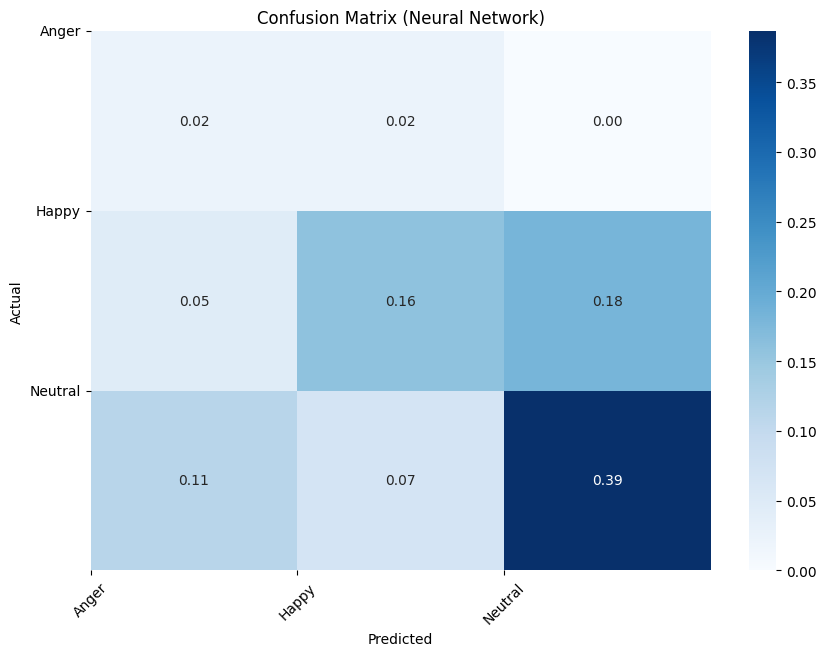

In [20]:
EPOCHS = 100
tf.random.set_seed(RANDOM_STATE)

input_shape = X_train.shape[1]
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, restore_best_weights=True)

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(input_shape,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
history = model.fit(X_resampled, y_resampled, epochs=EPOCHS, validation_split=0.1, batch_size=32, callbacks=[early_stopping])
y_pred = np.argmax(model.predict(X_test), axis=1)

actual_epochs = len(history.history['loss'])
if actual_epochs < EPOCHS:
    print(f"Early stopping activated after {actual_epochs} epochs.")
else:
    print("Training completed without early stopping.")

test_loss, test_acc = model.evaluate(X_test, y_test)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {test_acc * 100:.2f}%")
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Neural Network)')
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=label_encoder.classes_, rotation=45)
plt.yticks(ticks=np.arange(NUM_CLASSES), labels=label_encoder.classes_, rotation=0)
plt.show()